10. Construct a GAN model which can learn to generate fake images for MNIST fashion dataset

In [1]:
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4431872/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


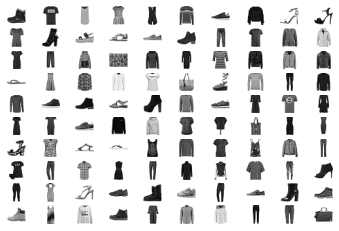

In [2]:
# plot raw pixel data
from matplotlib import pyplot
# plot images from the training dataset
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [3]:
#training an unconditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [5]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
	return model

In [6]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [7]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [8]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [10]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [11]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')


In [12]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)


2022-01-22 09:14:54.921707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 09:14:55.047933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 09:14:55.048616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 09:14:55.049742: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

>1, 1/468, d1=0.674, d2=0.696 g=0.691
>1, 2/468, d1=0.602, d2=0.703 g=0.685
>1, 3/468, d1=0.544, d2=0.713 g=0.675
>1, 4/468, d1=0.485, d2=0.729 g=0.663
>1, 5/468, d1=0.434, d2=0.746 g=0.647
>1, 6/468, d1=0.393, d2=0.770 g=0.631
>1, 7/468, d1=0.358, d2=0.792 g=0.621
>1, 8/468, d1=0.343, d2=0.805 g=0.621
>1, 9/468, d1=0.316, d2=0.806 g=0.638
>1, 10/468, d1=0.289, d2=0.776 g=0.684
>1, 11/468, d1=0.269, d2=0.716 g=0.770
>1, 12/468, d1=0.322, d2=0.621 g=0.874
>1, 13/468, d1=0.278, d2=0.547 g=0.985
>1, 14/468, d1=0.323, d2=0.479 g=1.075
>1, 15/468, d1=0.371, d2=0.477 g=1.034
>1, 16/468, d1=0.278, d2=0.519 g=0.942
>1, 17/468, d1=0.312, d2=0.588 g=0.835
>1, 18/468, d1=0.279, d2=0.655 g=0.751
>1, 19/468, d1=0.259, d2=0.733 g=0.680
>1, 20/468, d1=0.210, d2=0.875 g=0.587
>1, 21/468, d1=0.228, d2=1.020 g=0.507
>1, 22/468, d1=0.217, d2=1.102 g=0.486
>1, 23/468, d1=0.159, d2=1.075 g=0.516
>1, 24/468, d1=0.174, d2=0.979 g=0.588
>1, 25/468, d1=0.151, d2=0.847 g=0.718
>1, 26/468, d1=0.152, d2=0.668 g=0

2022-01-22 09:15:08.674422: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:15:08.713354: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1, 50/468, d1=0.181, d2=0.588 g=0.834
>1, 51/468, d1=0.156, d2=0.622 g=0.793
>1, 52/468, d1=0.118, d2=0.642 g=0.778
>1, 53/468, d1=0.090, d2=0.639 g=0.778
>1, 54/468, d1=0.101, d2=0.647 g=0.777
>1, 55/468, d1=0.112, d2=0.650 g=0.775


2022-01-22 09:15:09.044943: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1, 56/468, d1=0.095, d2=0.645 g=0.774
>1, 57/468, d1=0.086, d2=0.666 g=0.772
>1, 58/468, d1=0.073, d2=0.661 g=0.779
>1, 59/468, d1=0.087, d2=0.672 g=0.774
>1, 60/468, d1=0.094, d2=0.677 g=0.755
>1, 61/468, d1=0.171, d2=0.716 g=0.724
>1, 62/468, d1=0.112, d2=0.747 g=0.718
>1, 63/468, d1=0.117, d2=0.736 g=0.707
>1, 64/468, d1=0.116, d2=0.767 g=0.713
>1, 65/468, d1=0.142, d2=0.741 g=0.728
>1, 66/468, d1=0.154, d2=0.762 g=0.712
>1, 67/468, d1=0.140, d2=0.759 g=0.731
>1, 68/468, d1=0.187, d2=0.749 g=0.735
>1, 69/468, d1=0.144, d2=0.771 g=0.769
>1, 70/468, d1=0.172, d2=0.714 g=0.828
>1, 71/468, d1=0.237, d2=0.702 g=0.826
>1, 72/468, d1=0.251, d2=0.722 g=0.823
>1, 73/468, d1=0.235, d2=0.684 g=0.870
>1, 74/468, d1=0.267, d2=0.685 g=0.925
>1, 75/468, d1=0.322, d2=0.634 g=1.021
>1, 76/468, d1=0.365, d2=0.651 g=0.996
>1, 77/468, d1=0.408, d2=0.705 g=0.912
>1, 78/468, d1=0.409, d2=0.782 g=0.861
>1, 79/468, d1=0.372, d2=0.768 g=0.966
>1, 80/468, d1=0.442, d2=0.782 g=0.889
>1, 81/468, d1=0.416, d2=

2022-01-22 09:15:18.153871: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:15:18.244584: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1, 177/468, d1=0.616, d2=1.131 g=0.722
>1, 178/468, d1=0.605, d2=1.453 g=0.535


2022-01-22 09:15:18.416851: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:15:18.567160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1, 179/468, d1=0.752, d2=1.425 g=0.520
>1, 180/468, d1=0.913, d2=1.510 g=0.407
>1, 181/468, d1=0.984, d2=1.339 g=0.500
>1, 182/468, d1=0.846, d2=1.077 g=0.635
>1, 183/468, d1=0.783, d2=0.759 g=0.865
>1, 184/468, d1=0.740, d2=0.621 g=1.049


2022-01-22 09:15:18.834758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:15:18.894526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1, 185/468, d1=0.667, d2=0.454 g=1.186
>1, 186/468, d1=0.633, d2=0.462 g=1.155
>1, 187/468, d1=0.619, d2=0.619 g=0.990
>1, 188/468, d1=0.579, d2=0.718 g=0.973
>1, 189/468, d1=0.551, d2=0.834 g=0.839
>1, 190/468, d1=0.570, d2=0.870 g=0.703
>1, 191/468, d1=0.554, d2=0.992 g=0.667
>1, 192/468, d1=0.666, d2=1.007 g=0.672
>1, 193/468, d1=0.772, d2=0.885 g=0.775
>1, 194/468, d1=0.772, d2=0.703 g=0.902
>1, 195/468, d1=0.763, d2=0.604 g=1.022
>1, 196/468, d1=0.742, d2=0.513 g=1.085
>1, 197/468, d1=0.738, d2=0.474 g=1.169
>1, 198/468, d1=0.791, d2=0.446 g=1.212
>1, 199/468, d1=0.677, d2=0.402 g=1.262
>1, 200/468, d1=0.708, d2=0.406 g=1.321
>1, 201/468, d1=0.657, d2=0.363 g=1.352
>1, 202/468, d1=0.647, d2=0.344 g=1.385
>1, 203/468, d1=0.593, d2=0.356 g=1.430
>1, 204/468, d1=0.565, d2=0.324 g=1.439
>1, 205/468, d1=0.531, d2=0.352 g=1.411
>1, 206/468, d1=0.550, d2=0.430 g=1.251
>1, 207/468, d1=0.528, d2=0.557 g=1.055
>1, 208/468, d1=0.470, d2=0.672 g=0.968
>1, 209/468, d1=0.565, d2=0.709 g=0.906


2022-01-22 09:15:30.830804: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1, 350/468, d1=0.659, d2=0.710 g=0.741
>1, 351/468, d1=0.693, d2=0.770 g=0.711
>1, 352/468, d1=0.675, d2=0.802 g=0.727
>1, 353/468, d1=0.713, d2=0.785 g=0.705
>1, 354/468, d1=0.722, d2=0.734 g=0.715
>1, 355/468, d1=0.714, d2=0.758 g=0.741
>1, 356/468, d1=0.756, d2=0.690 g=0.791
>1, 357/468, d1=0.679, d2=0.659 g=0.819
>1, 358/468, d1=0.752, d2=0.605 g=0.847
>1, 359/468, d1=0.774, d2=0.587 g=0.905
>1, 360/468, d1=0.732, d2=0.568 g=0.905
>1, 361/468, d1=0.733, d2=0.538 g=0.943
>1, 362/468, d1=0.663, d2=0.517 g=0.943
>1, 363/468, d1=0.724, d2=0.545 g=0.954
>1, 364/468, d1=0.736, d2=0.558 g=0.918
>1, 365/468, d1=0.698, d2=0.562 g=0.891
>1, 366/468, d1=0.654, d2=0.580 g=0.862
>1, 367/468, d1=0.722, d2=0.612 g=0.821
>1, 368/468, d1=0.721, d2=0.663 g=0.779
>1, 369/468, d1=0.716, d2=0.711 g=0.728
>1, 370/468, d1=0.635, d2=0.717 g=0.682
>1, 371/468, d1=0.753, d2=0.815 g=0.664
>1, 372/468, d1=0.706, d2=0.777 g=0.646
>1, 373/468, d1=0.672, d2=0.800 g=0.663
>1, 374/468, d1=0.706, d2=0.786 g=0.655


2022-01-22 09:15:41.805505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:15:41.899956: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, 36/468, d1=0.718, d2=0.735 g=0.715
>2, 37/468, d1=0.713, d2=0.709 g=0.722
>2, 38/468, d1=0.706, d2=0.706 g=0.727


2022-01-22 09:15:42.034479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, 39/468, d1=0.713, d2=0.670 g=0.732
>2, 40/468, d1=0.731, d2=0.689 g=0.739
>2, 41/468, d1=0.702, d2=0.693 g=0.735
>2, 42/468, d1=0.693, d2=0.696 g=0.727
>2, 43/468, d1=0.712, d2=0.704 g=0.719
>2, 44/468, d1=0.702, d2=0.679 g=0.717
>2, 45/468, d1=0.709, d2=0.707 g=0.728
>2, 46/468, d1=0.703, d2=0.703 g=0.729
>2, 47/468, d1=0.679, d2=0.701 g=0.734
>2, 48/468, d1=0.704, d2=0.679 g=0.732
>2, 49/468, d1=0.701, d2=0.691 g=0.721
>2, 50/468, d1=0.669, d2=0.672 g=0.727
>2, 51/468, d1=0.660, d2=0.680 g=0.724
>2, 52/468, d1=0.678, d2=0.703 g=0.740
>2, 53/468, d1=0.655, d2=0.687 g=0.754
>2, 54/468, d1=0.651, d2=0.683 g=0.736
>2, 55/468, d1=0.665, d2=0.656 g=0.758
>2, 56/468, d1=0.659, d2=0.659 g=0.751
>2, 57/468, d1=0.641, d2=0.660 g=0.757
>2, 58/468, d1=0.646, d2=0.638 g=0.764
>2, 59/468, d1=0.669, d2=0.663 g=0.770
>2, 60/468, d1=0.652, d2=0.649 g=0.769
>2, 61/468, d1=0.629, d2=0.643 g=0.764
>2, 62/468, d1=0.663, d2=0.658 g=0.766
>2, 63/468, d1=0.612, d2=0.663 g=0.766
>2, 64/468, d1=0.667, d2=

2022-01-22 09:15:50.361245: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:15:50.403369: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:15:50.468061: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:15:50.506751: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, 158/468, d1=0.726, d2=0.698 g=0.719
>2, 159/468, d1=0.717, d2=0.686 g=0.721


2022-01-22 09:15:50.567543: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, 160/468, d1=0.720, d2=0.683 g=0.747
>2, 161/468, d1=0.718, d2=0.676 g=0.745
>2, 162/468, d1=0.721, d2=0.653 g=0.750
>2, 163/468, d1=0.709, d2=0.656 g=0.767


2022-01-22 09:15:50.942016: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, 164/468, d1=0.719, d2=0.654 g=0.761
>2, 165/468, d1=0.731, d2=0.658 g=0.768


2022-01-22 09:15:51.167155: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, 166/468, d1=0.705, d2=0.648 g=0.777
>2, 167/468, d1=0.695, d2=0.633 g=0.767
>2, 168/468, d1=0.682, d2=0.651 g=0.769
>2, 169/468, d1=0.663, d2=0.656 g=0.774
>2, 170/468, d1=0.664, d2=0.651 g=0.753
>2, 171/468, d1=0.680, d2=0.666 g=0.781
>2, 172/468, d1=0.672, d2=0.688 g=0.748
>2, 173/468, d1=0.672, d2=0.675 g=0.738
>2, 174/468, d1=0.701, d2=0.706 g=0.737
>2, 175/468, d1=0.686, d2=0.712 g=0.739
>2, 176/468, d1=0.724, d2=0.702 g=0.718
>2, 177/468, d1=0.716, d2=0.693 g=0.710
>2, 178/468, d1=0.695, d2=0.756 g=0.714
>2, 179/468, d1=0.698, d2=0.729 g=0.698
>2, 180/468, d1=0.700, d2=0.738 g=0.706
>2, 181/468, d1=0.702, d2=0.701 g=0.730
>2, 182/468, d1=0.748, d2=0.689 g=0.734
>2, 183/468, d1=0.716, d2=0.693 g=0.780
>2, 184/468, d1=0.721, d2=0.658 g=0.765
>2, 185/468, d1=0.711, d2=0.625 g=0.805
>2, 186/468, d1=0.719, d2=0.612 g=0.834
>2, 187/468, d1=0.714, d2=0.603 g=0.863
>2, 188/468, d1=0.709, d2=0.576 g=0.890
>2, 189/468, d1=0.746, d2=0.566 g=0.905
>2, 190/468, d1=0.695, d2=0.556 g=0.934


2022-01-22 09:15:55.214942: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:15:55.304951: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, 220/468, d1=0.635, d2=0.766 g=0.722
>2, 221/468, d1=0.654, d2=0.768 g=0.704
>2, 222/468, d1=0.661, d2=0.751 g=0.683
>2, 223/468, d1=0.709, d2=0.749 g=0.702
>2, 224/468, d1=0.694, d2=0.764 g=0.687
>2, 225/468, d1=0.707, d2=0.743 g=0.730
>2, 226/468, d1=0.691, d2=0.696 g=0.757
>2, 227/468, d1=0.687, d2=0.659 g=0.820
>2, 228/468, d1=0.686, d2=0.634 g=0.810
>2, 229/468, d1=0.688, d2=0.602 g=0.858
>2, 230/468, d1=0.706, d2=0.584 g=0.896
>2, 231/468, d1=0.693, d2=0.568 g=0.881
>2, 232/468, d1=0.676, d2=0.574 g=0.940
>2, 233/468, d1=0.690, d2=0.552 g=0.934
>2, 234/468, d1=0.690, d2=0.554 g=0.916
>2, 235/468, d1=0.713, d2=0.590 g=0.879
>2, 236/468, d1=0.709, d2=0.627 g=0.857
>2, 237/468, d1=0.679, d2=0.651 g=0.792
>2, 238/468, d1=0.697, d2=0.655 g=0.740
>2, 239/468, d1=0.699, d2=0.727 g=0.684
>2, 240/468, d1=0.705, d2=0.767 g=0.680
>2, 241/468, d1=0.703, d2=0.749 g=0.675
>2, 242/468, d1=0.687, d2=0.790 g=0.659
>2, 243/468, d1=0.661, d2=0.785 g=0.658
>2, 244/468, d1=0.677, d2=0.758 g=0.661


2022-01-22 09:16:22.174744: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 108/468, d1=0.709, d2=0.584 g=0.861
>3, 109/468, d1=0.689, d2=0.609 g=0.835
>3, 110/468, d1=0.686, d2=0.601 g=0.806


2022-01-22 09:16:22.428348: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:22.483923: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:22.600073: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 111/468, d1=0.672, d2=0.634 g=0.803
>3, 112/468, d1=0.696, d2=0.645 g=0.780
>3, 113/468, d1=0.683, d2=0.670 g=0.771


2022-01-22 09:16:22.737952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:22.790881: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:22.894755: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 114/468, d1=0.667, d2=0.669 g=0.749
>3, 115/468, d1=0.682, d2=0.665 g=0.750
>3, 116/468, d1=0.666, d2=0.678 g=0.740


2022-01-22 09:16:22.990653: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:23.079702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:23.172206: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 117/468, d1=0.683, d2=0.705 g=0.732
>3, 118/468, d1=0.680, d2=0.688 g=0.744
>3, 119/468, d1=0.670, d2=0.692 g=0.733
>3, 120/468, d1=0.655, d2=0.682 g=0.724
>3, 121/468, d1=0.657, d2=0.686 g=0.742
>3, 122/468, d1=0.655, d2=0.664 g=0.749
>3, 123/468, d1=0.663, d2=0.679 g=0.756
>3, 124/468, d1=0.654, d2=0.660 g=0.764
>3, 125/468, d1=0.676, d2=0.662 g=0.758
>3, 126/468, d1=0.675, d2=0.661 g=0.765
>3, 127/468, d1=0.686, d2=0.654 g=0.776
>3, 128/468, d1=0.659, d2=0.648 g=0.786
>3, 129/468, d1=0.660, d2=0.651 g=0.779
>3, 130/468, d1=0.695, d2=0.654 g=0.770
>3, 131/468, d1=0.668, d2=0.650 g=0.779
>3, 132/468, d1=0.689, d2=0.638 g=0.785
>3, 133/468, d1=0.678, d2=0.638 g=0.784
>3, 134/468, d1=0.685, d2=0.641 g=0.797
>3, 135/468, d1=0.695, d2=0.635 g=0.813
>3, 136/468, d1=0.715, d2=0.623 g=0.811
>3, 137/468, d1=0.714, d2=0.628 g=0.817
>3, 138/468, d1=0.702, d2=0.612 g=0.813
>3, 139/468, d1=0.731, d2=0.634 g=0.783
>3, 140/468, d1=0.709, d2=0.643 g=0.793
>3, 141/468, d1=0.700, d2=0.650 g=0.785


2022-01-22 09:16:25.459957: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 147/468, d1=0.710, d2=0.702 g=0.726
>3, 148/468, d1=0.699, d2=0.699 g=0.721
>3, 149/468, d1=0.702, d2=0.681 g=0.743


2022-01-22 09:16:25.808009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:25.845489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 150/468, d1=0.676, d2=0.669 g=0.736
>3, 151/468, d1=0.695, d2=0.702 g=0.739
>3, 152/468, d1=0.692, d2=0.680 g=0.743


2022-01-22 09:16:26.098776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 153/468, d1=0.695, d2=0.682 g=0.742
>3, 154/468, d1=0.684, d2=0.660 g=0.762
>3, 155/468, d1=0.697, d2=0.650 g=0.740
>3, 156/468, d1=0.704, d2=0.678 g=0.743
>3, 157/468, d1=0.694, d2=0.688 g=0.730
>3, 158/468, d1=0.688, d2=0.671 g=0.744
>3, 159/468, d1=0.675, d2=0.688 g=0.728
>3, 160/468, d1=0.652, d2=0.698 g=0.720
>3, 161/468, d1=0.651, d2=0.695 g=0.725
>3, 162/468, d1=0.692, d2=0.700 g=0.753
>3, 163/468, d1=0.706, d2=0.709 g=0.750
>3, 164/468, d1=0.707, d2=0.662 g=0.771
>3, 165/468, d1=0.715, d2=0.658 g=0.767
>3, 166/468, d1=0.706, d2=0.626 g=0.809
>3, 167/468, d1=0.730, d2=0.620 g=0.824
>3, 168/468, d1=0.707, d2=0.597 g=0.826
>3, 169/468, d1=0.715, d2=0.578 g=0.850
>3, 170/468, d1=0.723, d2=0.592 g=0.847
>3, 171/468, d1=0.717, d2=0.587 g=0.853
>3, 172/468, d1=0.719, d2=0.619 g=0.816
>3, 173/468, d1=0.713, d2=0.631 g=0.802
>3, 174/468, d1=0.720, d2=0.633 g=0.777
>3, 175/468, d1=0.702, d2=0.662 g=0.765
>3, 176/468, d1=0.682, d2=0.644 g=0.775
>3, 177/468, d1=0.677, d2=0.646 g=0.755


2022-01-22 09:16:32.025751: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 231/468, d1=0.642, d2=0.631 g=0.808
>3, 232/468, d1=0.627, d2=0.616 g=0.822
>3, 233/468, d1=0.640, d2=0.591 g=0.836
>3, 234/468, d1=0.603, d2=0.612 g=0.832
>3, 235/468, d1=0.599, d2=0.622 g=0.842
>3, 236/468, d1=0.637, d2=0.599 g=0.856
>3, 237/468, d1=0.654, d2=0.613 g=0.817
>3, 238/468, d1=0.623, d2=0.620 g=0.825
>3, 239/468, d1=0.651, d2=0.643 g=0.797
>3, 240/468, d1=0.634, d2=0.645 g=0.758
>3, 241/468, d1=0.661, d2=0.680 g=0.729
>3, 242/468, d1=0.632, d2=0.691 g=0.729
>3, 243/468, d1=0.628, d2=0.693 g=0.732
>3, 244/468, d1=0.660, d2=0.738 g=0.719
>3, 245/468, d1=0.642, d2=0.708 g=0.719
>3, 246/468, d1=0.659, d2=0.708 g=0.725
>3, 247/468, d1=0.684, d2=0.691 g=0.723
>3, 248/468, d1=0.663, d2=0.693 g=0.727
>3, 249/468, d1=0.644, d2=0.684 g=0.727
>3, 250/468, d1=0.642, d2=0.688 g=0.724
>3, 251/468, d1=0.637, d2=0.702 g=0.712
>3, 252/468, d1=0.647, d2=0.685 g=0.734
>3, 253/468, d1=0.670, d2=0.706 g=0.738
>3, 254/468, d1=0.653, d2=0.691 g=0.711
>3, 255/468, d1=0.671, d2=0.696 g=0.730


2022-01-22 09:16:36.546714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 292/468, d1=0.706, d2=0.646 g=0.780
>3, 293/468, d1=0.711, d2=0.648 g=0.794
>3, 294/468, d1=0.721, d2=0.641 g=0.796


2022-01-22 09:16:36.923563: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:36.959434: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:37.017530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 295/468, d1=0.732, d2=0.623 g=0.805
>3, 296/468, d1=0.718, d2=0.638 g=0.806
>3, 297/468, d1=0.707, d2=0.630 g=0.790
>3, 298/468, d1=0.708, d2=0.647 g=0.779
>3, 299/468, d1=0.700, d2=0.647 g=0.785
>3, 300/468, d1=0.705, d2=0.655 g=0.765
>3, 301/468, d1=0.694, d2=0.656 g=0.770
>3, 302/468, d1=0.662, d2=0.651 g=0.771
>3, 303/468, d1=0.669, d2=0.651 g=0.783
>3, 304/468, d1=0.652, d2=0.636 g=0.794
>3, 305/468, d1=0.674, d2=0.626 g=0.787
>3, 306/468, d1=0.617, d2=0.606 g=0.788
>3, 307/468, d1=0.646, d2=0.614 g=0.784
>3, 308/468, d1=0.642, d2=0.648 g=0.777
>3, 309/468, d1=0.625, d2=0.674 g=0.772
>3, 310/468, d1=0.644, d2=0.692 g=0.755
>3, 311/468, d1=0.671, d2=0.727 g=0.725
>3, 312/468, d1=0.658, d2=0.728 g=0.704
>3, 313/468, d1=0.635, d2=0.745 g=0.731
>3, 314/468, d1=0.674, d2=0.690 g=0.729
>3, 315/468, d1=0.660, d2=0.706 g=0.754
>3, 316/468, d1=0.639, d2=0.652 g=0.784
>3, 317/468, d1=0.694, d2=0.644 g=0.839
>3, 318/468, d1=0.688, d2=0.627 g=0.840
>3, 319/468, d1=0.713, d2=0.603 g=0.835


2022-01-22 09:16:47.637428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, 446/468, d1=0.656, d2=0.651 g=0.781
>3, 447/468, d1=0.646, d2=0.635 g=0.789
>3, 448/468, d1=0.663, d2=0.660 g=0.789
>3, 449/468, d1=0.681, d2=0.625 g=0.784
>3, 450/468, d1=0.655, d2=0.656 g=0.784
>3, 451/468, d1=0.676, d2=0.635 g=0.782
>3, 452/468, d1=0.649, d2=0.628 g=0.806
>3, 453/468, d1=0.653, d2=0.629 g=0.820
>3, 454/468, d1=0.659, d2=0.620 g=0.821
>3, 455/468, d1=0.643, d2=0.629 g=0.821
>3, 456/468, d1=0.649, d2=0.627 g=0.789
>3, 457/468, d1=0.639, d2=0.642 g=0.779
>3, 458/468, d1=0.649, d2=0.652 g=0.771
>3, 459/468, d1=0.655, d2=0.674 g=0.760
>3, 460/468, d1=0.660, d2=0.675 g=0.757
>3, 461/468, d1=0.642, d2=0.666 g=0.760
>3, 462/468, d1=0.639, d2=0.657 g=0.764
>3, 463/468, d1=0.688, d2=0.657 g=0.780
>3, 464/468, d1=0.659, d2=0.654 g=0.765
>3, 465/468, d1=0.664, d2=0.657 g=0.776
>3, 466/468, d1=0.681, d2=0.656 g=0.762
>3, 467/468, d1=0.649, d2=0.632 g=0.771
>3, 468/468, d1=0.652, d2=0.660 g=0.780
>4, 1/468, d1=0.686, d2=0.647 g=0.782
>4, 2/468, d1=0.685, d2=0.638 g=0.800
>4, 

2022-01-22 09:16:54.787421: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:54.853697: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, 72/468, d1=0.633, d2=0.666 g=0.784
>4, 73/468, d1=0.641, d2=0.647 g=0.799
>4, 74/468, d1=0.643, d2=0.638 g=0.805


2022-01-22 09:16:55.077293: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:55.167762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:55.203125: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, 75/468, d1=0.663, d2=0.628 g=0.823
>4, 76/468, d1=0.652, d2=0.611 g=0.824
>4, 77/468, d1=0.660, d2=0.607 g=0.840


2022-01-22 09:16:55.306684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:55.361501: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:55.399604: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:55.457116: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:16:55.494506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, 78/468, d1=0.638, d2=0.609 g=0.820
>4, 79/468, d1=0.674, d2=0.602 g=0.843
>4, 80/468, d1=0.663, d2=0.607 g=0.836
>4, 81/468, d1=0.664, d2=0.621 g=0.845
>4, 82/468, d1=0.669, d2=0.633 g=0.825
>4, 83/468, d1=0.643, d2=0.608 g=0.815
>4, 84/468, d1=0.663, d2=0.630 g=0.785
>4, 85/468, d1=0.636, d2=0.638 g=0.807
>4, 86/468, d1=0.647, d2=0.653 g=0.784
>4, 87/468, d1=0.664, d2=0.677 g=0.781
>4, 88/468, d1=0.665, d2=0.641 g=0.797
>4, 89/468, d1=0.664, d2=0.640 g=0.793
>4, 90/468, d1=0.678, d2=0.632 g=0.814
>4, 91/468, d1=0.689, d2=0.638 g=0.800
>4, 92/468, d1=0.680, d2=0.633 g=0.792
>4, 93/468, d1=0.702, d2=0.632 g=0.813
>4, 94/468, d1=0.676, d2=0.651 g=0.783
>4, 95/468, d1=0.703, d2=0.657 g=0.788
>4, 96/468, d1=0.700, d2=0.650 g=0.791
>4, 97/468, d1=0.699, d2=0.663 g=0.780
>4, 98/468, d1=0.688, d2=0.644 g=0.771
>4, 99/468, d1=0.700, d2=0.643 g=0.776
>4, 100/468, d1=0.687, d2=0.627 g=0.790
>4, 101/468, d1=0.684, d2=0.650 g=0.798
>4, 102/468, d1=0.672, d2=0.637 g=0.790
>4, 103/468, d1=0.658,

2022-01-22 09:16:59.056213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, 126/468, d1=0.662, d2=0.637 g=0.791
>4, 127/468, d1=0.661, d2=0.625 g=0.812
>4, 128/468, d1=0.668, d2=0.648 g=0.821
>4, 129/468, d1=0.673, d2=0.623 g=0.800
>4, 130/468, d1=0.665, d2=0.648 g=0.822
>4, 131/468, d1=0.704, d2=0.631 g=0.845
>4, 132/468, d1=0.719, d2=0.613 g=0.859
>4, 133/468, d1=0.711, d2=0.603 g=0.849
>4, 134/468, d1=0.691, d2=0.621 g=0.848
>4, 135/468, d1=0.706, d2=0.600 g=0.829
>4, 136/468, d1=0.719, d2=0.614 g=0.830
>4, 137/468, d1=0.697, d2=0.621 g=0.840
>4, 138/468, d1=0.664, d2=0.615 g=0.830
>4, 139/468, d1=0.714, d2=0.608 g=0.827
>4, 140/468, d1=0.679, d2=0.621 g=0.834
>4, 141/468, d1=0.713, d2=0.608 g=0.820
>4, 142/468, d1=0.652, d2=0.603 g=0.826
>4, 143/468, d1=0.698, d2=0.621 g=0.822
>4, 144/468, d1=0.669, d2=0.624 g=0.846
>4, 145/468, d1=0.690, d2=0.621 g=0.828
>4, 146/468, d1=0.673, d2=0.611 g=0.843
>4, 147/468, d1=0.667, d2=0.611 g=0.814
>4, 148/468, d1=0.693, d2=0.630 g=0.814
>4, 149/468, d1=0.654, d2=0.643 g=0.836
>4, 150/468, d1=0.661, d2=0.633 g=0.832


2022-01-22 09:17:09.655529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:09.694572: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:09.758090: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, 269/468, d1=0.664, d2=0.649 g=0.814
>4, 270/468, d1=0.674, d2=0.650 g=0.798
>4, 271/468, d1=0.679, d2=0.632 g=0.792
>4, 272/468, d1=0.642, d2=0.662 g=0.810
>4, 273/468, d1=0.643, d2=0.639 g=0.803
>4, 274/468, d1=0.679, d2=0.604 g=0.800
>4, 275/468, d1=0.647, d2=0.625 g=0.800
>4, 276/468, d1=0.661, d2=0.662 g=0.821
>4, 277/468, d1=0.655, d2=0.627 g=0.810
>4, 278/468, d1=0.635, d2=0.653 g=0.813
>4, 279/468, d1=0.657, d2=0.615 g=0.817
>4, 280/468, d1=0.680, d2=0.640 g=0.808
>4, 281/468, d1=0.668, d2=0.601 g=0.815
>4, 282/468, d1=0.666, d2=0.615 g=0.839
>4, 283/468, d1=0.665, d2=0.638 g=0.814
>4, 284/468, d1=0.695, d2=0.612 g=0.788
>4, 285/468, d1=0.650, d2=0.642 g=0.797
>4, 286/468, d1=0.668, d2=0.665 g=0.781
>4, 287/468, d1=0.647, d2=0.653 g=0.767
>4, 288/468, d1=0.639, d2=0.669 g=0.788
>4, 289/468, d1=0.705, d2=0.660 g=0.785
>4, 290/468, d1=0.691, d2=0.659 g=0.792
>4, 291/468, d1=0.711, d2=0.633 g=0.804
>4, 292/468, d1=0.688, d2=0.656 g=0.801
>4, 293/468, d1=0.693, d2=0.640 g=0.795


2022-01-22 09:17:14.497846: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, 332/468, d1=0.626, d2=0.645 g=0.793
>4, 333/468, d1=0.661, d2=0.650 g=0.808
>4, 334/468, d1=0.631, d2=0.653 g=0.807
>4, 335/468, d1=0.640, d2=0.654 g=0.805
>4, 336/468, d1=0.675, d2=0.611 g=0.820
>4, 337/468, d1=0.682, d2=0.613 g=0.845
>4, 338/468, d1=0.662, d2=0.615 g=0.842
>4, 339/468, d1=0.698, d2=0.646 g=0.815
>4, 340/468, d1=0.670, d2=0.621 g=0.798
>4, 341/468, d1=0.707, d2=0.634 g=0.796
>4, 342/468, d1=0.665, d2=0.645 g=0.780
>4, 343/468, d1=0.633, d2=0.658 g=0.793
>4, 344/468, d1=0.683, d2=0.641 g=0.792
>4, 345/468, d1=0.670, d2=0.641 g=0.782
>4, 346/468, d1=0.644, d2=0.632 g=0.776
>4, 347/468, d1=0.625, d2=0.636 g=0.788
>4, 348/468, d1=0.672, d2=0.644 g=0.788
>4, 349/468, d1=0.647, d2=0.654 g=0.797
>4, 350/468, d1=0.642, d2=0.658 g=0.811
>4, 351/468, d1=0.691, d2=0.662 g=0.824
>4, 352/468, d1=0.682, d2=0.611 g=0.855
>4, 353/468, d1=0.677, d2=0.604 g=0.858
>4, 354/468, d1=0.688, d2=0.581 g=0.854
>4, 355/468, d1=0.718, d2=0.619 g=0.841
>4, 356/468, d1=0.689, d2=0.635 g=0.808


2022-01-22 09:17:26.776441: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:26.839885: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:26.877291: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5, 29/468, d1=0.625, d2=0.642 g=0.793
>5, 30/468, d1=0.643, d2=0.656 g=0.786
>5, 31/468, d1=0.649, d2=0.651 g=0.787
>5, 32/468, d1=0.630, d2=0.672 g=0.794
>5, 33/468, d1=0.676, d2=0.663 g=0.781


2022-01-22 09:17:27.139173: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:27.225202: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:27.313928: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5, 34/468, d1=0.658, d2=0.646 g=0.792
>5, 35/468, d1=0.648, d2=0.645 g=0.793
>5, 36/468, d1=0.654, d2=0.643 g=0.801


2022-01-22 09:17:27.349626: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:27.440067: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:27.498062: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5, 37/468, d1=0.629, d2=0.651 g=0.788
>5, 38/468, d1=0.665, d2=0.665 g=0.791
>5, 39/468, d1=0.673, d2=0.674 g=0.795
>5, 40/468, d1=0.621, d2=0.640 g=0.779
>5, 41/468, d1=0.656, d2=0.671 g=0.777
>5, 42/468, d1=0.665, d2=0.676 g=0.772
>5, 43/468, d1=0.639, d2=0.678 g=0.772
>5, 44/468, d1=0.637, d2=0.648 g=0.766
>5, 45/468, d1=0.704, d2=0.674 g=0.774
>5, 46/468, d1=0.642, d2=0.649 g=0.787
>5, 47/468, d1=0.675, d2=0.651 g=0.797
>5, 48/468, d1=0.678, d2=0.652 g=0.794
>5, 49/468, d1=0.667, d2=0.672 g=0.800
>5, 50/468, d1=0.675, d2=0.644 g=0.792
>5, 51/468, d1=0.685, d2=0.641 g=0.789
>5, 52/468, d1=0.677, d2=0.640 g=0.771
>5, 53/468, d1=0.668, d2=0.659 g=0.787
>5, 54/468, d1=0.670, d2=0.658 g=0.770
>5, 55/468, d1=0.678, d2=0.657 g=0.764
>5, 56/468, d1=0.667, d2=0.679 g=0.777
>5, 57/468, d1=0.658, d2=0.677 g=0.759
>5, 58/468, d1=0.669, d2=0.674 g=0.769
>5, 59/468, d1=0.691, d2=0.657 g=0.770
>5, 60/468, d1=0.672, d2=0.683 g=0.761
>5, 61/468, d1=0.642, d2=0.693 g=0.762
>5, 62/468, d1=0.656, d2=

2022-01-22 09:17:31.844657: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:31.879958: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:32.037772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5, 97/468, d1=0.702, d2=0.664 g=0.785
>5, 98/468, d1=0.656, d2=0.686 g=0.789
>5, 99/468, d1=0.664, d2=0.665 g=0.794
>5, 100/468, d1=0.691, d2=0.634 g=0.801
>5, 101/468, d1=0.688, d2=0.647 g=0.784
>5, 102/468, d1=0.691, d2=0.662 g=0.775
>5, 103/468, d1=0.677, d2=0.652 g=0.764
>5, 104/468, d1=0.664, d2=0.659 g=0.766
>5, 105/468, d1=0.639, d2=0.668 g=0.769
>5, 106/468, d1=0.652, d2=0.673 g=0.754
>5, 107/468, d1=0.680, d2=0.672 g=0.761
>5, 108/468, d1=0.683, d2=0.697 g=0.770
>5, 109/468, d1=0.642, d2=0.647 g=0.773
>5, 110/468, d1=0.646, d2=0.660 g=0.775
>5, 111/468, d1=0.672, d2=0.674 g=0.813
>5, 112/468, d1=0.671, d2=0.654 g=0.791
>5, 113/468, d1=0.682, d2=0.643 g=0.833
>5, 114/468, d1=0.674, d2=0.637 g=0.837
>5, 115/468, d1=0.703, d2=0.606 g=0.848
>5, 116/468, d1=0.714, d2=0.605 g=0.824
>5, 117/468, d1=0.703, d2=0.612 g=0.825
>5, 118/468, d1=0.680, d2=0.632 g=0.825
>5, 119/468, d1=0.723, d2=0.653 g=0.773
>5, 120/468, d1=0.671, d2=0.653 g=0.767
>5, 121/468, d1=0.677, d2=0.651 g=0.777
>5,

2022-01-22 09:17:53.497400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5, 396/468, d1=0.656, d2=0.711 g=0.725
>5, 397/468, d1=0.659, d2=0.681 g=0.745
>5, 398/468, d1=0.687, d2=0.683 g=0.747
>5, 399/468, d1=0.682, d2=0.691 g=0.763


2022-01-22 09:17:53.939933: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5, 400/468, d1=0.625, d2=0.643 g=0.768
>5, 401/468, d1=0.636, d2=0.695 g=0.763
>5, 402/468, d1=0.639, d2=0.692 g=0.734
>5, 403/468, d1=0.663, d2=0.737 g=0.716
>5, 404/468, d1=0.610, d2=0.746 g=0.718
>5, 405/468, d1=0.634, d2=0.739 g=0.748
>5, 406/468, d1=0.676, d2=0.703 g=0.769
>5, 407/468, d1=0.658, d2=0.648 g=0.828
>5, 408/468, d1=0.700, d2=0.611 g=0.815
>5, 409/468, d1=0.692, d2=0.613 g=0.883
>5, 410/468, d1=0.714, d2=0.637 g=0.826
>5, 411/468, d1=0.729, d2=0.621 g=0.792
>5, 412/468, d1=0.712, d2=0.685 g=0.770
>5, 413/468, d1=0.654, d2=0.676 g=0.735
>5, 414/468, d1=0.655, d2=0.699 g=0.723
>5, 415/468, d1=0.683, d2=0.709 g=0.720
>5, 416/468, d1=0.651, d2=0.707 g=0.730
>5, 417/468, d1=0.632, d2=0.671 g=0.749
>5, 418/468, d1=0.628, d2=0.679 g=0.761
>5, 419/468, d1=0.656, d2=0.663 g=0.753
>5, 420/468, d1=0.593, d2=0.689 g=0.734
>5, 421/468, d1=0.617, d2=0.782 g=0.679
>5, 422/468, d1=0.631, d2=0.837 g=0.665
>5, 423/468, d1=0.632, d2=0.807 g=0.686
>5, 424/468, d1=0.678, d2=0.750 g=0.764


2022-01-22 09:17:56.530938: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5, 436/468, d1=0.619, d2=0.654 g=0.812
>5, 437/468, d1=0.615, d2=0.618 g=0.783
>5, 438/468, d1=0.720, d2=0.707 g=0.757
>5, 439/468, d1=0.632, d2=0.734 g=0.712
>5, 440/468, d1=0.604, d2=0.749 g=0.715
>5, 441/468, d1=0.616, d2=0.799 g=0.696
>5, 442/468, d1=0.668, d2=0.757 g=0.743
>5, 443/468, d1=0.680, d2=0.681 g=0.800
>5, 444/468, d1=0.708, d2=0.646 g=0.845
>5, 445/468, d1=0.694, d2=0.587 g=0.850
>5, 446/468, d1=0.737, d2=0.577 g=0.849
>5, 447/468, d1=0.701, d2=0.611 g=0.845
>5, 448/468, d1=0.723, d2=0.645 g=0.843
>5, 449/468, d1=0.717, d2=0.653 g=0.778
>5, 450/468, d1=0.724, d2=0.654 g=0.754
>5, 451/468, d1=0.706, d2=0.710 g=0.726
>5, 452/468, d1=0.682, d2=0.725 g=0.722
>5, 453/468, d1=0.694, d2=0.705 g=0.747
>5, 454/468, d1=0.672, d2=0.674 g=0.768
>5, 455/468, d1=0.654, d2=0.676 g=0.781
>5, 456/468, d1=0.640, d2=0.664 g=0.776
>5, 457/468, d1=0.665, d2=0.707 g=0.746
>5, 458/468, d1=0.617, d2=0.700 g=0.697
>5, 459/468, d1=0.653, d2=0.761 g=0.719
>5, 460/468, d1=0.652, d2=0.737 g=0.707


2022-01-22 09:17:59.759236: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:17:59.958667: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, 13/468, d1=0.635, d2=0.732 g=0.708
>6, 14/468, d1=0.657, d2=0.738 g=0.716


2022-01-22 09:18:00.174234: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:00.230664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:00.361102: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, 15/468, d1=0.651, d2=0.728 g=0.733
>6, 16/468, d1=0.691, d2=0.711 g=0.763
>6, 17/468, d1=0.678, d2=0.680 g=0.788


2022-01-22 09:18:00.433678: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:00.558916: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:00.613385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, 18/468, d1=0.668, d2=0.669 g=0.796
>6, 19/468, d1=0.666, d2=0.670 g=0.811
>6, 20/468, d1=0.721, d2=0.689 g=0.808
>6, 21/468, d1=0.694, d2=0.646 g=0.765
>6, 22/468, d1=0.696, d2=0.689 g=0.749
>6, 23/468, d1=0.682, d2=0.712 g=0.739
>6, 24/468, d1=0.674, d2=0.704 g=0.743
>6, 25/468, d1=0.667, d2=0.678 g=0.731
>6, 26/468, d1=0.686, d2=0.684 g=0.747
>6, 27/468, d1=0.697, d2=0.710 g=0.737
>6, 28/468, d1=0.644, d2=0.701 g=0.724
>6, 29/468, d1=0.671, d2=0.690 g=0.736
>6, 30/468, d1=0.657, d2=0.690 g=0.740
>6, 31/468, d1=0.664, d2=0.721 g=0.733
>6, 32/468, d1=0.661, d2=0.699 g=0.737
>6, 33/468, d1=0.659, d2=0.699 g=0.779
>6, 34/468, d1=0.679, d2=0.669 g=0.769
>6, 35/468, d1=0.707, d2=0.653 g=0.792
>6, 36/468, d1=0.718, d2=0.641 g=0.771
>6, 37/468, d1=0.714, d2=0.620 g=0.823
>6, 38/468, d1=0.686, d2=0.668 g=0.806
>6, 39/468, d1=0.700, d2=0.623 g=0.781
>6, 40/468, d1=0.726, d2=0.654 g=0.798
>6, 41/468, d1=0.719, d2=0.664 g=0.758
>6, 42/468, d1=0.703, d2=0.683 g=0.751
>6, 43/468, d1=0.708, d2=

2022-01-22 09:18:04.513569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, 75/468, d1=0.765, d2=0.615 g=0.805
>6, 76/468, d1=0.734, d2=0.667 g=0.764
>6, 77/468, d1=0.726, d2=0.707 g=0.735
>6, 78/468, d1=0.715, d2=0.721 g=0.726
>6, 79/468, d1=0.672, d2=0.708 g=0.737
>6, 80/468, d1=0.676, d2=0.699 g=0.764
>6, 81/468, d1=0.682, d2=0.665 g=0.790
>6, 82/468, d1=0.674, d2=0.647 g=0.793
>6, 83/468, d1=0.661, d2=0.667 g=0.745
>6, 84/468, d1=0.650, d2=0.704 g=0.757
>6, 85/468, d1=0.643, d2=0.712 g=0.718
>6, 86/468, d1=0.638, d2=0.688 g=0.670
>6, 87/468, d1=0.706, d2=0.783 g=0.690
>6, 88/468, d1=0.661, d2=0.741 g=0.733
>6, 89/468, d1=0.687, d2=0.706 g=0.746
>6, 90/468, d1=0.703, d2=0.652 g=0.804
>6, 91/468, d1=0.705, d2=0.631 g=0.835
>6, 92/468, d1=0.720, d2=0.587 g=0.865
>6, 93/468, d1=0.755, d2=0.602 g=0.859
>6, 94/468, d1=0.720, d2=0.589 g=0.872
>6, 95/468, d1=0.767, d2=0.607 g=0.803
>6, 96/468, d1=0.715, d2=0.656 g=0.797
>6, 97/468, d1=0.666, d2=0.676 g=0.742
>6, 98/468, d1=0.716, d2=0.730 g=0.720
>6, 99/468, d1=0.679, d2=0.723 g=0.705
>6, 100/468, d1=0.717, d2

2022-01-22 09:18:15.739984: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, 231/468, d1=0.681, d2=0.672 g=0.728
>6, 232/468, d1=0.712, d2=0.681 g=0.721
>6, 233/468, d1=0.680, d2=0.706 g=0.715
>6, 234/468, d1=0.685, d2=0.704 g=0.725
>6, 235/468, d1=0.678, d2=0.689 g=0.730
>6, 236/468, d1=0.691, d2=0.698 g=0.731
>6, 237/468, d1=0.688, d2=0.675 g=0.737
>6, 238/468, d1=0.667, d2=0.692 g=0.721
>6, 239/468, d1=0.670, d2=0.666 g=0.732
>6, 240/468, d1=0.666, d2=0.701 g=0.706
>6, 241/468, d1=0.704, d2=0.721 g=0.697
>6, 242/468, d1=0.673, d2=0.745 g=0.715
>6, 243/468, d1=0.693, d2=0.713 g=0.725
>6, 244/468, d1=0.698, d2=0.695 g=0.739
>6, 245/468, d1=0.681, d2=0.680 g=0.767
>6, 246/468, d1=0.694, d2=0.672 g=0.780
>6, 247/468, d1=0.703, d2=0.672 g=0.765
>6, 248/468, d1=0.725, d2=0.653 g=0.755
>6, 249/468, d1=0.722, d2=0.673 g=0.747
>6, 250/468, d1=0.701, d2=0.684 g=0.731
>6, 251/468, d1=0.705, d2=0.691 g=0.739
>6, 252/468, d1=0.685, d2=0.695 g=0.722
>6, 253/468, d1=0.691, d2=0.696 g=0.726
>6, 254/468, d1=0.708, d2=0.680 g=0.735
>6, 255/468, d1=0.679, d2=0.665 g=0.739


2022-01-22 09:18:27.015087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:27.078455: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, 389/468, d1=0.713, d2=0.696 g=0.742
>6, 390/468, d1=0.728, d2=0.697 g=0.732
>6, 391/468, d1=0.700, d2=0.678 g=0.740
>6, 392/468, d1=0.695, d2=0.650 g=0.765
>6, 393/468, d1=0.710, d2=0.661 g=0.736
>6, 394/468, d1=0.699, d2=0.687 g=0.744
>6, 395/468, d1=0.696, d2=0.674 g=0.719
>6, 396/468, d1=0.685, d2=0.717 g=0.722
>6, 397/468, d1=0.668, d2=0.695 g=0.711
>6, 398/468, d1=0.704, d2=0.702 g=0.719
>6, 399/468, d1=0.691, d2=0.704 g=0.712
>6, 400/468, d1=0.703, d2=0.708 g=0.723
>6, 401/468, d1=0.696, d2=0.711 g=0.751
>6, 402/468, d1=0.716, d2=0.653 g=0.744
>6, 403/468, d1=0.714, d2=0.658 g=0.761
>6, 404/468, d1=0.705, d2=0.656 g=0.750
>6, 405/468, d1=0.709, d2=0.673 g=0.733
>6, 406/468, d1=0.720, d2=0.687 g=0.724
>6, 407/468, d1=0.694, d2=0.697 g=0.716
>6, 408/468, d1=0.695, d2=0.692 g=0.720
>6, 409/468, d1=0.682, d2=0.678 g=0.725
>6, 410/468, d1=0.680, d2=0.697 g=0.724
>6, 411/468, d1=0.647, d2=0.705 g=0.718
>6, 412/468, d1=0.658, d2=0.707 g=0.705
>6, 413/468, d1=0.653, d2=0.717 g=0.705


2022-01-22 09:18:33.245252: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 7/468, d1=0.687, d2=0.688 g=0.726
>7, 8/468, d1=0.686, d2=0.690 g=0.718


2022-01-22 09:18:33.585616: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:33.729332: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 9/468, d1=0.680, d2=0.698 g=0.693
>7, 10/468, d1=0.688, d2=0.732 g=0.705
>7, 11/468, d1=0.693, d2=0.701 g=0.731
>7, 12/468, d1=0.683, d2=0.696 g=0.740
>7, 13/468, d1=0.699, d2=0.671 g=0.753


2022-01-22 09:18:33.896824: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:33.985568: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 14/468, d1=0.696, d2=0.704 g=0.746
>7, 15/468, d1=0.690, d2=0.686 g=0.729
>7, 16/468, d1=0.702, d2=0.723 g=0.707
>7, 17/468, d1=0.688, d2=0.669 g=0.717
>7, 18/468, d1=0.700, d2=0.729 g=0.716
>7, 19/468, d1=0.692, d2=0.705 g=0.703
>7, 20/468, d1=0.680, d2=0.706 g=0.731
>7, 21/468, d1=0.713, d2=0.694 g=0.723
>7, 22/468, d1=0.712, d2=0.670 g=0.742
>7, 23/468, d1=0.684, d2=0.680 g=0.731
>7, 24/468, d1=0.739, d2=0.710 g=0.710
>7, 25/468, d1=0.680, d2=0.700 g=0.731
>7, 26/468, d1=0.674, d2=0.692 g=0.730
>7, 27/468, d1=0.702, d2=0.696 g=0.717
>7, 28/468, d1=0.683, d2=0.683 g=0.726
>7, 29/468, d1=0.700, d2=0.710 g=0.726
>7, 30/468, d1=0.691, d2=0.707 g=0.716
>7, 31/468, d1=0.703, d2=0.708 g=0.724
>7, 32/468, d1=0.684, d2=0.678 g=0.736
>7, 33/468, d1=0.674, d2=0.697 g=0.727
>7, 34/468, d1=0.674, d2=0.688 g=0.714
>7, 35/468, d1=0.676, d2=0.733 g=0.706
>7, 36/468, d1=0.687, d2=0.694 g=0.709
>7, 37/468, d1=0.677, d2=0.704 g=0.710
>7, 38/468, d1=0.676, d2=0.691 g=0.721
>7, 39/468, d1=0.698, d2=

2022-01-22 09:18:37.733085: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 66/468, d1=0.702, d2=0.717 g=0.709
>7, 67/468, d1=0.681, d2=0.706 g=0.702
>7, 68/468, d1=0.678, d2=0.686 g=0.740


2022-01-22 09:18:37.985663: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 69/468, d1=0.660, d2=0.716 g=0.748
>7, 70/468, d1=0.659, d2=0.676 g=0.737
>7, 71/468, d1=0.651, d2=0.697 g=0.721
>7, 72/468, d1=0.701, d2=0.723 g=0.707
>7, 73/468, d1=0.694, d2=0.726 g=0.694
>7, 74/468, d1=0.660, d2=0.711 g=0.696
>7, 75/468, d1=0.670, d2=0.725 g=0.687
>7, 76/468, d1=0.696, d2=0.705 g=0.720
>7, 77/468, d1=0.680, d2=0.686 g=0.752
>7, 78/468, d1=0.701, d2=0.649 g=0.769
>7, 79/468, d1=0.715, d2=0.650 g=0.756
>7, 80/468, d1=0.712, d2=0.674 g=0.756
>7, 81/468, d1=0.715, d2=0.699 g=0.741
>7, 82/468, d1=0.695, d2=0.695 g=0.728
>7, 83/468, d1=0.735, d2=0.693 g=0.714
>7, 84/468, d1=0.676, d2=0.691 g=0.732
>7, 85/468, d1=0.699, d2=0.680 g=0.732
>7, 86/468, d1=0.682, d2=0.676 g=0.732
>7, 87/468, d1=0.699, d2=0.691 g=0.740
>7, 88/468, d1=0.682, d2=0.693 g=0.734
>7, 89/468, d1=0.691, d2=0.668 g=0.723
>7, 90/468, d1=0.686, d2=0.709 g=0.720
>7, 91/468, d1=0.693, d2=0.695 g=0.720
>7, 92/468, d1=0.693, d2=0.690 g=0.700
>7, 93/468, d1=0.672, d2=0.704 g=0.726
>7, 94/468, d1=0.712, d2=

2022-01-22 09:18:48.934438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:49.003946: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 225/468, d1=0.679, d2=0.685 g=0.714
>7, 226/468, d1=0.680, d2=0.702 g=0.704
>7, 227/468, d1=0.656, d2=0.687 g=0.710
>7, 228/468, d1=0.674, d2=0.705 g=0.699
>7, 229/468, d1=0.674, d2=0.718 g=0.696
>7, 230/468, d1=0.666, d2=0.694 g=0.715
>7, 231/468, d1=0.674, d2=0.724 g=0.721
>7, 232/468, d1=0.680, d2=0.719 g=0.709
>7, 233/468, d1=0.681, d2=0.687 g=0.717
>7, 234/468, d1=0.694, d2=0.680 g=0.721
>7, 235/468, d1=0.687, d2=0.684 g=0.714
>7, 236/468, d1=0.666, d2=0.693 g=0.727
>7, 237/468, d1=0.680, d2=0.698 g=0.714
>7, 238/468, d1=0.694, d2=0.707 g=0.722
>7, 239/468, d1=0.677, d2=0.688 g=0.720
>7, 240/468, d1=0.698, d2=0.688 g=0.717
>7, 241/468, d1=0.656, d2=0.698 g=0.722
>7, 242/468, d1=0.690, d2=0.708 g=0.708
>7, 243/468, d1=0.681, d2=0.702 g=0.708
>7, 244/468, d1=0.681, d2=0.691 g=0.707
>7, 245/468, d1=0.683, d2=0.708 g=0.694
>7, 246/468, d1=0.675, d2=0.719 g=0.702
>7, 247/468, d1=0.681, d2=0.718 g=0.691
>7, 248/468, d1=0.650, d2=0.709 g=0.717
>7, 249/468, d1=0.670, d2=0.705 g=0.705


2022-01-22 09:18:57.537936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:57.604954: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:57.639946: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 348/468, d1=0.680, d2=0.698 g=0.719
>7, 349/468, d1=0.681, d2=0.695 g=0.732
>7, 350/468, d1=0.681, d2=0.684 g=0.760


2022-01-22 09:18:57.879929: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 351/468, d1=0.696, d2=0.666 g=0.743
>7, 352/468, d1=0.711, d2=0.693 g=0.731
>7, 353/468, d1=0.699, d2=0.693 g=0.733
>7, 354/468, d1=0.682, d2=0.698 g=0.738
>7, 355/468, d1=0.701, d2=0.693 g=0.713
>7, 356/468, d1=0.704, d2=0.697 g=0.705
>7, 357/468, d1=0.679, d2=0.699 g=0.713
>7, 358/468, d1=0.697, d2=0.712 g=0.710
>7, 359/468, d1=0.673, d2=0.697 g=0.723
>7, 360/468, d1=0.682, d2=0.705 g=0.716
>7, 361/468, d1=0.668, d2=0.718 g=0.740
>7, 362/468, d1=0.685, d2=0.719 g=0.712
>7, 363/468, d1=0.676, d2=0.694 g=0.695
>7, 364/468, d1=0.680, d2=0.738 g=0.702
>7, 365/468, d1=0.680, d2=0.713 g=0.720
>7, 366/468, d1=0.697, d2=0.706 g=0.716
>7, 367/468, d1=0.694, d2=0.701 g=0.732
>7, 368/468, d1=0.700, d2=0.675 g=0.756
>7, 369/468, d1=0.725, d2=0.656 g=0.756
>7, 370/468, d1=0.705, d2=0.651 g=0.748
>7, 371/468, d1=0.704, d2=0.669 g=0.749
>7, 372/468, d1=0.710, d2=0.687 g=0.737
>7, 373/468, d1=0.685, d2=0.682 g=0.715
>7, 374/468, d1=0.711, d2=0.688 g=0.712
>7, 375/468, d1=0.698, d2=0.683 g=0.717


2022-01-22 09:18:59.670182: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:59.770738: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:18:59.922517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 376/468, d1=0.681, d2=0.686 g=0.720
>7, 377/468, d1=0.698, d2=0.709 g=0.727
>7, 378/468, d1=0.690, d2=0.680 g=0.730
>7, 379/468, d1=0.653, d2=0.722 g=0.720
>7, 380/468, d1=0.683, d2=0.700 g=0.706
>7, 381/468, d1=0.648, d2=0.725 g=0.690
>7, 382/468, d1=0.663, d2=0.712 g=0.682
>7, 383/468, d1=0.687, d2=0.726 g=0.702
>7, 384/468, d1=0.674, d2=0.720 g=0.705
>7, 385/468, d1=0.675, d2=0.687 g=0.740
>7, 386/468, d1=0.699, d2=0.673 g=0.737
>7, 387/468, d1=0.691, d2=0.671 g=0.745
>7, 388/468, d1=0.679, d2=0.652 g=0.745
>7, 389/468, d1=0.703, d2=0.667 g=0.757
>7, 390/468, d1=0.709, d2=0.678 g=0.741
>7, 391/468, d1=0.716, d2=0.699 g=0.733
>7, 392/468, d1=0.678, d2=0.674 g=0.726
>7, 393/468, d1=0.698, d2=0.681 g=0.734
>7, 394/468, d1=0.680, d2=0.685 g=0.720
>7, 395/468, d1=0.684, d2=0.682 g=0.726
>7, 396/468, d1=0.658, d2=0.696 g=0.719
>7, 397/468, d1=0.661, d2=0.691 g=0.709
>7, 398/468, d1=0.687, d2=0.713 g=0.701
>7, 399/468, d1=0.674, d2=0.704 g=0.701
>7, 400/468, d1=0.673, d2=0.717 g=0.700


2022-01-22 09:19:06.005758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 464/468, d1=0.687, d2=0.691 g=0.723
>7, 465/468, d1=0.702, d2=0.697 g=0.717
>7, 466/468, d1=0.685, d2=0.695 g=0.723


2022-01-22 09:19:06.225496: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, 467/468, d1=0.681, d2=0.691 g=0.705
>7, 468/468, d1=0.692, d2=0.692 g=0.709
>8, 1/468, d1=0.679, d2=0.695 g=0.714


2022-01-22 09:19:06.575817: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:06.609978: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:06.753382: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, 2/468, d1=0.692, d2=0.690 g=0.720
>8, 3/468, d1=0.674, d2=0.696 g=0.708


2022-01-22 09:19:06.792277: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:06.869806: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, 4/468, d1=0.671, d2=0.715 g=0.706
>8, 5/468, d1=0.689, d2=0.721 g=0.693
>8, 6/468, d1=0.688, d2=0.738 g=0.710
>8, 7/468, d1=0.681, d2=0.702 g=0.715
>8, 8/468, d1=0.719, d2=0.700 g=0.720
>8, 9/468, d1=0.670, d2=0.656 g=0.727
>8, 10/468, d1=0.679, d2=0.674 g=0.742
>8, 11/468, d1=0.704, d2=0.693 g=0.722
>8, 12/468, d1=0.697, d2=0.671 g=0.721
>8, 13/468, d1=0.689, d2=0.690 g=0.721
>8, 14/468, d1=0.699, d2=0.714 g=0.709
>8, 15/468, d1=0.693, d2=0.703 g=0.712
>8, 16/468, d1=0.677, d2=0.696 g=0.713
>8, 17/468, d1=0.689, d2=0.699 g=0.720
>8, 18/468, d1=0.683, d2=0.701 g=0.714
>8, 19/468, d1=0.696, d2=0.682 g=0.717
>8, 20/468, d1=0.683, d2=0.691 g=0.721
>8, 21/468, d1=0.690, d2=0.686 g=0.697
>8, 22/468, d1=0.689, d2=0.706 g=0.713
>8, 23/468, d1=0.672, d2=0.699 g=0.722
>8, 24/468, d1=0.669, d2=0.701 g=0.701
>8, 25/468, d1=0.677, d2=0.716 g=0.710
>8, 26/468, d1=0.694, d2=0.699 g=0.731
>8, 27/468, d1=0.697, d2=0.688 g=0.747
>8, 28/468, d1=0.706, d2=0.675 g=0.738
>8, 29/468, d1=0.719, d2=0.682 

2022-01-22 09:19:28.381948: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, 309/468, d1=0.686, d2=0.680 g=0.714
>8, 310/468, d1=0.695, d2=0.699 g=0.724
>8, 311/468, d1=0.706, d2=0.693 g=0.716
>8, 312/468, d1=0.686, d2=0.679 g=0.714
>8, 313/468, d1=0.694, d2=0.698 g=0.712
>8, 314/468, d1=0.701, d2=0.687 g=0.717
>8, 315/468, d1=0.695, d2=0.690 g=0.723
>8, 316/468, d1=0.698, d2=0.685 g=0.719
>8, 317/468, d1=0.705, d2=0.695 g=0.721
>8, 318/468, d1=0.702, d2=0.686 g=0.718
>8, 319/468, d1=0.692, d2=0.687 g=0.718
>8, 320/468, d1=0.694, d2=0.696 g=0.712
>8, 321/468, d1=0.690, d2=0.698 g=0.724
>8, 322/468, d1=0.697, d2=0.692 g=0.713
>8, 323/468, d1=0.683, d2=0.702 g=0.724
>8, 324/468, d1=0.693, d2=0.699 g=0.721
>8, 325/468, d1=0.682, d2=0.685 g=0.710
>8, 326/468, d1=0.713, d2=0.697 g=0.727
>8, 327/468, d1=0.706, d2=0.676 g=0.728
>8, 328/468, d1=0.700, d2=0.670 g=0.740
>8, 329/468, d1=0.711, d2=0.674 g=0.744
>8, 330/468, d1=0.715, d2=0.672 g=0.730
>8, 331/468, d1=0.696, d2=0.684 g=0.727
>8, 332/468, d1=0.719, d2=0.681 g=0.717
>8, 333/468, d1=0.688, d2=0.678 g=0.731


2022-01-22 09:19:39.106002: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:39.164336: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:39.270394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:39.305354: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, 459/468, d1=0.667, d2=0.725 g=0.694
>8, 460/468, d1=0.687, d2=0.726 g=0.694
>8, 461/468, d1=0.669, d2=0.709 g=0.702
>8, 462/468, d1=0.694, d2=0.721 g=0.700
>8, 463/468, d1=0.688, d2=0.686 g=0.721
>8, 464/468, d1=0.696, d2=0.683 g=0.753


2022-01-22 09:19:39.735475: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, 465/468, d1=0.693, d2=0.667 g=0.755
>8, 466/468, d1=0.716, d2=0.656 g=0.751
>8, 467/468, d1=0.729, d2=0.684 g=0.734
>8, 468/468, d1=0.718, d2=0.683 g=0.713
>9, 1/468, d1=0.710, d2=0.713 g=0.706
>9, 2/468, d1=0.718, d2=0.699 g=0.709
>9, 3/468, d1=0.674, d2=0.693 g=0.719
>9, 4/468, d1=0.701, d2=0.681 g=0.746
>9, 5/468, d1=0.697, d2=0.679 g=0.744
>9, 6/468, d1=0.674, d2=0.688 g=0.730
>9, 7/468, d1=0.706, d2=0.681 g=0.715
>9, 8/468, d1=0.689, d2=0.719 g=0.708
>9, 9/468, d1=0.674, d2=0.729 g=0.712
>9, 10/468, d1=0.672, d2=0.712 g=0.706
>9, 11/468, d1=0.693, d2=0.704 g=0.712
>9, 12/468, d1=0.689, d2=0.705 g=0.721
>9, 13/468, d1=0.693, d2=0.686 g=0.742
>9, 14/468, d1=0.710, d2=0.682 g=0.757
>9, 15/468, d1=0.685, d2=0.661 g=0.753
>9, 16/468, d1=0.731, d2=0.680 g=0.739
>9, 17/468, d1=0.703, d2=0.673 g=0.728
>9, 18/468, d1=0.700, d2=0.664 g=0.725
>9, 19/468, d1=0.706, d2=0.687 g=0.728
>9, 20/468, d1=0.687, d2=0.700 g=0.722
>9, 21/468, d1=0.691, d2=0.698 g=0.713
>9, 22/468, d1=0.701, d2=0.686

2022-01-22 09:19:43.771162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:43.823343: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:43.857828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:43.913125: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:19:43.949468: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, 53/468, d1=0.703, d2=0.688 g=0.714
>9, 54/468, d1=0.703, d2=0.704 g=0.715
>9, 55/468, d1=0.702, d2=0.692 g=0.713
>9, 56/468, d1=0.702, d2=0.687 g=0.711
>9, 57/468, d1=0.701, d2=0.702 g=0.722
>9, 58/468, d1=0.675, d2=0.692 g=0.717
>9, 59/468, d1=0.692, d2=0.698 g=0.709
>9, 60/468, d1=0.708, d2=0.687 g=0.721
>9, 61/468, d1=0.700, d2=0.697 g=0.706
>9, 62/468, d1=0.679, d2=0.716 g=0.710
>9, 63/468, d1=0.663, d2=0.707 g=0.717
>9, 64/468, d1=0.666, d2=0.705 g=0.714
>9, 65/468, d1=0.681, d2=0.699 g=0.711
>9, 66/468, d1=0.693, d2=0.695 g=0.712
>9, 67/468, d1=0.696, d2=0.699 g=0.713
>9, 68/468, d1=0.683, d2=0.679 g=0.712
>9, 69/468, d1=0.681, d2=0.696 g=0.731
>9, 70/468, d1=0.692, d2=0.685 g=0.722
>9, 71/468, d1=0.689, d2=0.691 g=0.721
>9, 72/468, d1=0.697, d2=0.685 g=0.713
>9, 73/468, d1=0.700, d2=0.687 g=0.705
>9, 74/468, d1=0.683, d2=0.696 g=0.700
>9, 75/468, d1=0.684, d2=0.692 g=0.711
>9, 76/468, d1=0.675, d2=0.702 g=0.715
>9, 77/468, d1=0.681, d2=0.698 g=0.711
>9, 78/468, d1=0.692, d2=

2022-01-22 09:19:54.694709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, 207/468, d1=0.699, d2=0.705 g=0.725
>9, 208/468, d1=0.695, d2=0.687 g=0.745
>9, 209/468, d1=0.705, d2=0.663 g=0.754
>9, 210/468, d1=0.707, d2=0.677 g=0.728
>9, 211/468, d1=0.689, d2=0.669 g=0.731
>9, 212/468, d1=0.713, d2=0.678 g=0.721
>9, 213/468, d1=0.700, d2=0.671 g=0.715
>9, 214/468, d1=0.716, d2=0.674 g=0.716
>9, 215/468, d1=0.705, d2=0.687 g=0.713
>9, 216/468, d1=0.668, d2=0.699 g=0.714
>9, 217/468, d1=0.659, d2=0.686 g=0.711
>9, 218/468, d1=0.677, d2=0.691 g=0.721
>9, 219/468, d1=0.687, d2=0.699 g=0.735
>9, 220/468, d1=0.677, d2=0.698 g=0.722
>9, 221/468, d1=0.689, d2=0.720 g=0.698
>9, 222/468, d1=0.667, d2=0.720 g=0.723
>9, 223/468, d1=0.682, d2=0.716 g=0.713
>9, 224/468, d1=0.697, d2=0.681 g=0.715
>9, 225/468, d1=0.693, d2=0.685 g=0.738
>9, 226/468, d1=0.701, d2=0.681 g=0.741
>9, 227/468, d1=0.721, d2=0.674 g=0.750
>9, 228/468, d1=0.720, d2=0.682 g=0.736
>9, 229/468, d1=0.706, d2=0.681 g=0.739
>9, 230/468, d1=0.717, d2=0.683 g=0.722
>9, 231/468, d1=0.694, d2=0.697 g=0.725


2022-01-22 09:19:58.702936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, 260/468, d1=0.684, d2=0.697 g=0.695
>9, 261/468, d1=0.680, d2=0.688 g=0.709
>9, 262/468, d1=0.694, d2=0.687 g=0.722
>9, 263/468, d1=0.694, d2=0.678 g=0.723
>9, 264/468, d1=0.705, d2=0.677 g=0.741
>9, 265/468, d1=0.704, d2=0.658 g=0.737
>9, 266/468, d1=0.686, d2=0.662 g=0.739
>9, 267/468, d1=0.706, d2=0.696 g=0.714
>9, 268/468, d1=0.714, d2=0.707 g=0.701
>9, 269/468, d1=0.698, d2=0.699 g=0.700
>9, 270/468, d1=0.688, d2=0.707 g=0.704
>9, 271/468, d1=0.677, d2=0.697 g=0.701
>9, 272/468, d1=0.677, d2=0.693 g=0.715
>9, 273/468, d1=0.677, d2=0.685 g=0.710
>9, 274/468, d1=0.673, d2=0.694 g=0.716
>9, 275/468, d1=0.699, d2=0.713 g=0.717
>9, 276/468, d1=0.671, d2=0.710 g=0.716
>9, 277/468, d1=0.679, d2=0.714 g=0.723
>9, 278/468, d1=0.692, d2=0.720 g=0.702
>9, 279/468, d1=0.694, d2=0.693 g=0.725
>9, 280/468, d1=0.688, d2=0.680 g=0.733
>9, 281/468, d1=0.695, d2=0.676 g=0.742
>9, 282/468, d1=0.703, d2=0.666 g=0.749
>9, 283/468, d1=0.727, d2=0.674 g=0.731
>9, 284/468, d1=0.699, d2=0.686 g=0.736


2022-01-22 09:20:05.727205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, 358/468, d1=0.687, d2=0.699 g=0.703
>9, 359/468, d1=0.690, d2=0.690 g=0.706
>9, 360/468, d1=0.692, d2=0.702 g=0.705


2022-01-22 09:20:06.028294: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, 361/468, d1=0.681, d2=0.716 g=0.709
>9, 362/468, d1=0.690, d2=0.706 g=0.718
>9, 363/468, d1=0.682, d2=0.672 g=0.719
>9, 364/468, d1=0.684, d2=0.675 g=0.726
>9, 365/468, d1=0.682, d2=0.689 g=0.719
>9, 366/468, d1=0.705, d2=0.690 g=0.716
>9, 367/468, d1=0.703, d2=0.693 g=0.731
>9, 368/468, d1=0.682, d2=0.701 g=0.713
>9, 369/468, d1=0.684, d2=0.696 g=0.709
>9, 370/468, d1=0.693, d2=0.691 g=0.716
>9, 371/468, d1=0.678, d2=0.687 g=0.711
>9, 372/468, d1=0.695, d2=0.690 g=0.713
>9, 373/468, d1=0.713, d2=0.704 g=0.721
>9, 374/468, d1=0.676, d2=0.701 g=0.713
>9, 375/468, d1=0.675, d2=0.703 g=0.707
>9, 376/468, d1=0.702, d2=0.707 g=0.709
>9, 377/468, d1=0.707, d2=0.704 g=0.705
>9, 378/468, d1=0.693, d2=0.695 g=0.718
>9, 379/468, d1=0.689, d2=0.700 g=0.717
>9, 380/468, d1=0.675, d2=0.691 g=0.710
>9, 381/468, d1=0.688, d2=0.689 g=0.723
>9, 382/468, d1=0.692, d2=0.682 g=0.718
>9, 383/468, d1=0.683, d2=0.700 g=0.726
>9, 384/468, d1=0.689, d2=0.690 g=0.700
>9, 385/468, d1=0.683, d2=0.702 g=0.708


2022-01-22 09:20:12.028977: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:12.145028: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, 446/468, d1=0.701, d2=0.689 g=0.730
>9, 447/468, d1=0.700, d2=0.691 g=0.722
>9, 448/468, d1=0.690, d2=0.688 g=0.719
>9, 449/468, d1=0.707, d2=0.684 g=0.710
>9, 450/468, d1=0.706, d2=0.691 g=0.726
>9, 451/468, d1=0.692, d2=0.678 g=0.715


2022-01-22 09:20:12.539549: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:12.662746: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, 452/468, d1=0.680, d2=0.690 g=0.708
>9, 453/468, d1=0.690, d2=0.689 g=0.715
>9, 454/468, d1=0.692, d2=0.693 g=0.711


2022-01-22 09:20:12.761031: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:12.859960: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, 455/468, d1=0.680, d2=0.692 g=0.711
>9, 456/468, d1=0.690, d2=0.708 g=0.715
>9, 457/468, d1=0.682, d2=0.696 g=0.721
>9, 458/468, d1=0.722, d2=0.694 g=0.719
>9, 459/468, d1=0.704, d2=0.678 g=0.713
>9, 460/468, d1=0.687, d2=0.678 g=0.725
>9, 461/468, d1=0.712, d2=0.695 g=0.723
>9, 462/468, d1=0.701, d2=0.689 g=0.735
>9, 463/468, d1=0.692, d2=0.690 g=0.729
>9, 464/468, d1=0.714, d2=0.669 g=0.730
>9, 465/468, d1=0.714, d2=0.677 g=0.725
>9, 466/468, d1=0.696, d2=0.687 g=0.721
>9, 467/468, d1=0.691, d2=0.691 g=0.714
>9, 468/468, d1=0.708, d2=0.691 g=0.707
>10, 1/468, d1=0.696, d2=0.671 g=0.716
>10, 2/468, d1=0.701, d2=0.701 g=0.709
>10, 3/468, d1=0.688, d2=0.686 g=0.709
>10, 4/468, d1=0.688, d2=0.698 g=0.705
>10, 5/468, d1=0.680, d2=0.697 g=0.717
>10, 6/468, d1=0.701, d2=0.712 g=0.715
>10, 7/468, d1=0.704, d2=0.696 g=0.728
>10, 8/468, d1=0.692, d2=0.700 g=0.719
>10, 9/468, d1=0.689, d2=0.690 g=0.719
>10, 10/468, d1=0.680, d2=0.685 g=0.731
>10, 11/468, d1=0.674, d2=0.699 g=0.727
>10, 12/4

2022-01-22 09:20:16.667028: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 40/468, d1=0.684, d2=0.704 g=0.699
>10, 41/468, d1=0.704, d2=0.699 g=0.708
>10, 42/468, d1=0.696, d2=0.693 g=0.722


2022-01-22 09:20:16.907268: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 43/468, d1=0.695, d2=0.691 g=0.723
>10, 44/468, d1=0.684, d2=0.683 g=0.722
>10, 45/468, d1=0.686, d2=0.696 g=0.717
>10, 46/468, d1=0.664, d2=0.693 g=0.705
>10, 47/468, d1=0.693, d2=0.706 g=0.716
>10, 48/468, d1=0.693, d2=0.693 g=0.719
>10, 49/468, d1=0.696, d2=0.688 g=0.723
>10, 50/468, d1=0.712, d2=0.682 g=0.739
>10, 51/468, d1=0.699, d2=0.680 g=0.740
>10, 52/468, d1=0.711, d2=0.684 g=0.733
>10, 53/468, d1=0.711, d2=0.692 g=0.731
>10, 54/468, d1=0.716, d2=0.670 g=0.738
>10, 55/468, d1=0.716, d2=0.687 g=0.740
>10, 56/468, d1=0.713, d2=0.671 g=0.718
>10, 57/468, d1=0.692, d2=0.686 g=0.715
>10, 58/468, d1=0.707, d2=0.679 g=0.720
>10, 59/468, d1=0.701, d2=0.685 g=0.720
>10, 60/468, d1=0.703, d2=0.681 g=0.718
>10, 61/468, d1=0.700, d2=0.690 g=0.722
>10, 62/468, d1=0.689, d2=0.695 g=0.723
>10, 63/468, d1=0.708, d2=0.691 g=0.709
>10, 64/468, d1=0.688, d2=0.694 g=0.704
>10, 65/468, d1=0.696, d2=0.705 g=0.696
>10, 66/468, d1=0.686, d2=0.713 g=0.712
>10, 67/468, d1=0.674, d2=0.693 g=0.717


2022-01-22 09:20:27.681962: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:27.716946: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:27.776507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 195/468, d1=0.681, d2=0.695 g=0.716
>10, 196/468, d1=0.691, d2=0.685 g=0.711
>10, 197/468, d1=0.682, d2=0.695 g=0.710
>10, 198/468, d1=0.692, d2=0.705 g=0.717
>10, 199/468, d1=0.689, d2=0.698 g=0.712
>10, 200/468, d1=0.684, d2=0.699 g=0.709
>10, 201/468, d1=0.692, d2=0.695 g=0.721
>10, 202/468, d1=0.688, d2=0.692 g=0.715
>10, 203/468, d1=0.678, d2=0.688 g=0.725
>10, 204/468, d1=0.679, d2=0.696 g=0.716
>10, 205/468, d1=0.697, d2=0.690 g=0.720
>10, 206/468, d1=0.678, d2=0.692 g=0.710
>10, 207/468, d1=0.686, d2=0.691 g=0.710
>10, 208/468, d1=0.699, d2=0.684 g=0.715
>10, 209/468, d1=0.680, d2=0.682 g=0.708
>10, 210/468, d1=0.679, d2=0.697 g=0.722
>10, 211/468, d1=0.685, d2=0.685 g=0.713
>10, 212/468, d1=0.675, d2=0.680 g=0.720
>10, 213/468, d1=0.696, d2=0.701 g=0.724
>10, 214/468, d1=0.695, d2=0.686 g=0.726
>10, 215/468, d1=0.697, d2=0.680 g=0.713
>10, 216/468, d1=0.686, d2=0.683 g=0.720
>10, 217/468, d1=0.688, d2=0.685 g=0.717


2022-01-22 09:20:29.332953: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:29.425934: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 218/468, d1=0.680, d2=0.687 g=0.724
>10, 219/468, d1=0.682, d2=0.698 g=0.710
>10, 220/468, d1=0.700, d2=0.685 g=0.720
>10, 221/468, d1=0.707, d2=0.686 g=0.722
>10, 222/468, d1=0.693, d2=0.674 g=0.711
>10, 223/468, d1=0.691, d2=0.681 g=0.718


2022-01-22 09:20:29.716626: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:29.811026: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 224/468, d1=0.687, d2=0.689 g=0.715
>10, 225/468, d1=0.688, d2=0.685 g=0.731
>10, 226/468, d1=0.680, d2=0.677 g=0.722


2022-01-22 09:20:29.994288: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 227/468, d1=0.689, d2=0.677 g=0.724
>10, 228/468, d1=0.691, d2=0.697 g=0.721
>10, 229/468, d1=0.682, d2=0.689 g=0.714
>10, 230/468, d1=0.703, d2=0.694 g=0.716
>10, 231/468, d1=0.672, d2=0.681 g=0.723
>10, 232/468, d1=0.700, d2=0.688 g=0.725
>10, 233/468, d1=0.700, d2=0.672 g=0.727
>10, 234/468, d1=0.694, d2=0.693 g=0.726
>10, 235/468, d1=0.693, d2=0.690 g=0.720
>10, 236/468, d1=0.682, d2=0.690 g=0.718
>10, 237/468, d1=0.684, d2=0.684 g=0.710
>10, 238/468, d1=0.704, d2=0.671 g=0.725
>10, 239/468, d1=0.691, d2=0.701 g=0.713
>10, 240/468, d1=0.694, d2=0.703 g=0.708
>10, 241/468, d1=0.703, d2=0.690 g=0.713
>10, 242/468, d1=0.698, d2=0.687 g=0.709
>10, 243/468, d1=0.677, d2=0.705 g=0.711
>10, 244/468, d1=0.684, d2=0.701 g=0.707
>10, 245/468, d1=0.689, d2=0.707 g=0.701
>10, 246/468, d1=0.672, d2=0.692 g=0.707
>10, 247/468, d1=0.678, d2=0.695 g=0.705
>10, 248/468, d1=0.684, d2=0.700 g=0.723
>10, 249/468, d1=0.685, d2=0.677 g=0.715
>10, 250/468, d1=0.691, d2=0.691 g=0.712
>10, 251/468, d1

2022-01-22 09:20:38.636784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:38.732396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 348/468, d1=0.703, d2=0.685 g=0.720
>10, 349/468, d1=0.686, d2=0.684 g=0.725
>10, 350/468, d1=0.684, d2=0.683 g=0.722


2022-01-22 09:20:38.865126: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 351/468, d1=0.692, d2=0.692 g=0.723
>10, 352/468, d1=0.693, d2=0.695 g=0.732
>10, 353/468, d1=0.693, d2=0.685 g=0.727
>10, 354/468, d1=0.695, d2=0.679 g=0.721
>10, 355/468, d1=0.698, d2=0.692 g=0.719
>10, 356/468, d1=0.698, d2=0.691 g=0.728
>10, 357/468, d1=0.690, d2=0.689 g=0.730
>10, 358/468, d1=0.708, d2=0.686 g=0.717
>10, 359/468, d1=0.688, d2=0.677 g=0.720
>10, 360/468, d1=0.687, d2=0.678 g=0.718
>10, 361/468, d1=0.689, d2=0.677 g=0.734
>10, 362/468, d1=0.692, d2=0.678 g=0.707
>10, 363/468, d1=0.680, d2=0.690 g=0.706
>10, 364/468, d1=0.686, d2=0.707 g=0.722
>10, 365/468, d1=0.693, d2=0.686 g=0.712
>10, 366/468, d1=0.710, d2=0.684 g=0.722
>10, 367/468, d1=0.702, d2=0.689 g=0.714
>10, 368/468, d1=0.703, d2=0.680 g=0.719
>10, 369/468, d1=0.691, d2=0.699 g=0.713
>10, 370/468, d1=0.697, d2=0.688 g=0.716
>10, 371/468, d1=0.706, d2=0.689 g=0.708
>10, 372/468, d1=0.679, d2=0.682 g=0.713
>10, 373/468, d1=0.692, d2=0.683 g=0.714
>10, 374/468, d1=0.690, d2=0.693 g=0.709
>10, 375/468, d1

2022-01-22 09:20:44.494479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 431/468, d1=0.694, d2=0.680 g=0.719
>10, 432/468, d1=0.679, d2=0.676 g=0.718
>10, 433/468, d1=0.695, d2=0.671 g=0.725
>10, 434/468, d1=0.687, d2=0.709 g=0.725
>10, 435/468, d1=0.692, d2=0.688 g=0.725
>10, 436/468, d1=0.708, d2=0.693 g=0.736
>10, 437/468, d1=0.689, d2=0.680 g=0.718
>10, 438/468, d1=0.697, d2=0.684 g=0.730


2022-01-22 09:20:45.046035: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:45.143331: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 439/468, d1=0.700, d2=0.694 g=0.717
>10, 440/468, d1=0.700, d2=0.675 g=0.727
>10, 441/468, d1=0.725, d2=0.672 g=0.735


2022-01-22 09:20:45.377199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:45.430192: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:45.465964: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:45.527125: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:45.562604: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 442/468, d1=0.709, d2=0.681 g=0.720
>10, 443/468, d1=0.703, d2=0.689 g=0.719
>10, 444/468, d1=0.702, d2=0.680 g=0.714


2022-01-22 09:20:45.657132: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-01-22 09:20:45.752963: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, 445/468, d1=0.709, d2=0.698 g=0.722
>10, 446/468, d1=0.706, d2=0.687 g=0.723
>10, 447/468, d1=0.695, d2=0.695 g=0.737
>10, 448/468, d1=0.700, d2=0.681 g=0.730
>10, 449/468, d1=0.715, d2=0.683 g=0.720
>10, 450/468, d1=0.698, d2=0.677 g=0.725
>10, 451/468, d1=0.708, d2=0.674 g=0.727
>10, 452/468, d1=0.700, d2=0.666 g=0.715
>10, 453/468, d1=0.703, d2=0.666 g=0.719
>10, 454/468, d1=0.699, d2=0.681 g=0.725
>10, 455/468, d1=0.697, d2=0.693 g=0.717
>10, 456/468, d1=0.698, d2=0.703 g=0.715
>10, 457/468, d1=0.701, d2=0.689 g=0.703
>10, 458/468, d1=0.680, d2=0.688 g=0.712
>10, 459/468, d1=0.685, d2=0.707 g=0.722
>10, 460/468, d1=0.682, d2=0.696 g=0.717
>10, 461/468, d1=0.700, d2=0.688 g=0.707
>10, 462/468, d1=0.694, d2=0.682 g=0.717
>10, 463/468, d1=0.692, d2=0.673 g=0.713
>10, 464/468, d1=0.686, d2=0.681 g=0.722
>10, 465/468, d1=0.690, d2=0.700 g=0.709
>10, 466/468, d1=0.672, d2=0.682 g=0.710
>10, 467/468, d1=0.691, d2=0.691 g=0.714
>10, 468/468, d1=0.678, d2=0.684 g=0.715


In [13]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

In [14]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [15]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

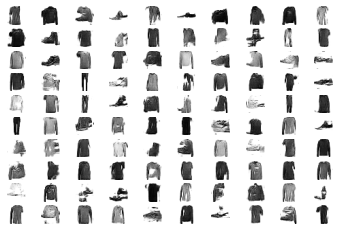

In [16]:
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)